# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache

## 0.2 Define parameters

In [4]:
bw = 64
experiment = 'equiangular'
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
download = False
train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=bw, 
                                    augmentation=augmentation, nfile=None, experiment = experiment)


31364it [00:38, 811.16it/s]


In [8]:
val_dataset = Shrec17Dataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=bw, 
                                 augmentation=augmentation, nfile=None, experiment = experiment)

5133it [00:07, 690.13it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

Number of elements / class


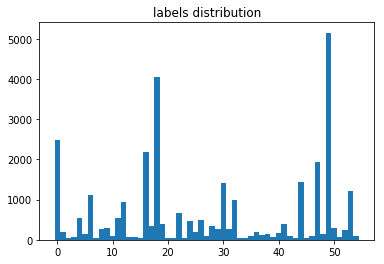

In [9]:
# Not necessary if datasetCache is used
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

In [10]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364 
first id: 010507


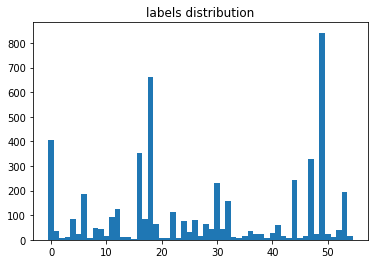

In [11]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [12]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
im1_norm = x_train[0,:,1]
im0003_norm = train_dataset.data[0,:,1]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(x_train[:,:,0])
cmax = np.max(x_train[:,:,0])
cmin_norm = np.min(x_train[:,:,1])
cmax_norm = np.max(x_train[:,:,1])

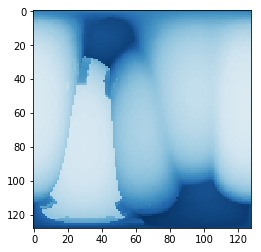

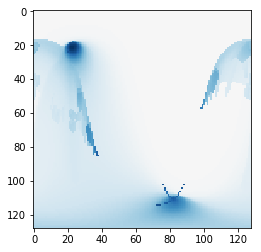

In [13]:
plt.imshow(im1.reshape((2*bw,2*bw)), cmap=cm, vmin = cmin, vmax = cmax)
plt.figure()
plt.imshow(im0003.reshape((2*bw,2*bw)), cmap=cm, vmin = cmin, vmax = cmax)

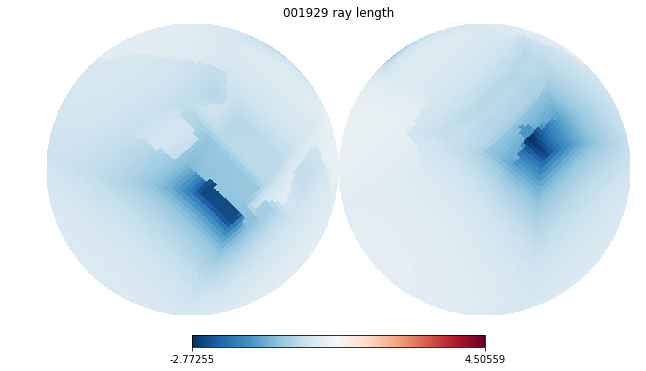

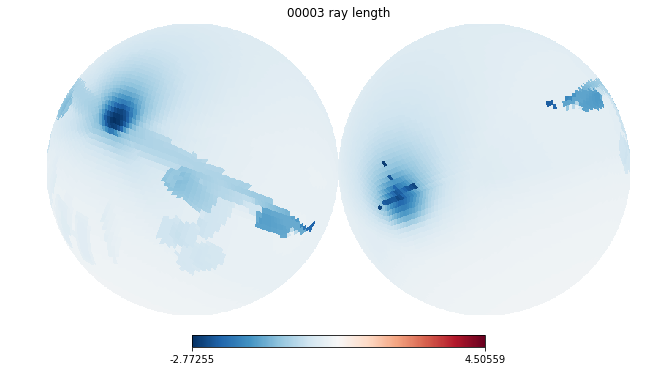

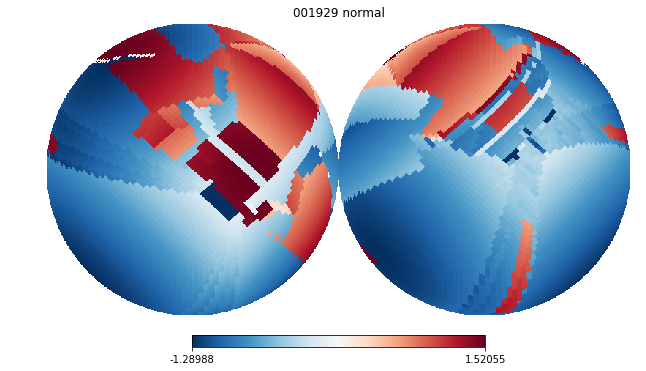

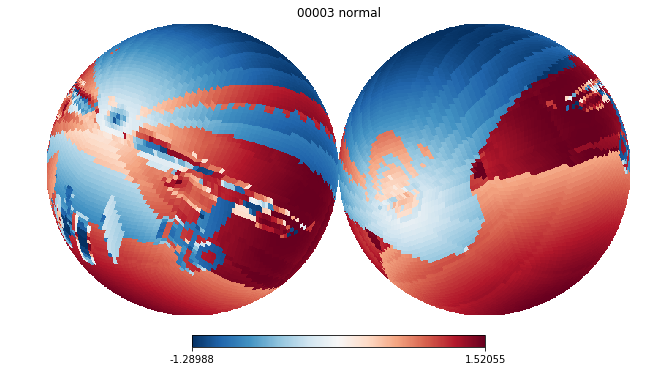

In [16]:
# hp.orthview(im1, title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
# hp.orthview(im0003, rot=(90,90,290), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
# hp.orthview(im1_norm, title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin_norm, max=cmax_norm)
# hp.orthview(im0003_norm, rot=(90,90,290), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin_norm, max=cmax_norm)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [14]:
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [15]:
EXP_NAME = 'shrec17_equiangular_SGD_max_bw_{}bw{}'.format(bw, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"
#EXP_NAME = 'plop'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [16]:
params = hyperparameters.get_params_shrec17_equiangular(num_elem, EXP_NAME, nclass, architecture=experiment_type)
model = models.deepsphere(**params)

bandwidth: 64
#pixels: [16384, 1024, 400]
#samples per batch: 32
=> #pixels per batch (input): 524,288
=> #pixels for training (input): 51,386,777,600
Learning rate will start at 5.0e-01 and finish at 5.0e-01.
NN architecture
  input: M_0 = 16384
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 16384 * 100 / 16 = 102400
    weights: F_0 * F_1 * K_1 = 6 * 100 * 64 = 38400
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 1024 * 100 / 1 = 102400
    weights: F_1 * F_2 * K_2 = 100 * 100 * 16 = 160000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [40]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [18]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(training, validation)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 56 = 33600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.35e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.45 (23 / 5133), f1 (weighted): 0.28, loss: 4.20e+00
  CPU time: 247s, wall time: 976s, perf_time: 0.62s
step 2940 / 19602 (epoch 3.00 / 20):
  learning_rate = 3.16e-05, training loss = 3.72e+00
  validation accuracy: 3.37 (173 / 5133), f1 (weighted): 2.86, loss: 3.97e+00
  CPU time: 470s, wall time: 1889s, perf_time: 0.56s
step 4410 / 19602 (epoch 4.50 / 20):
  learning_rate = 1.78e-04, training loss = 3.29e+00
  validation accuracy: 31.09 (1596 / 5133), f1 (weighted): 19.99, loss: 3.17e+00
  CPU time: 686s, wall time: 2769s, perf_time: 0.57s
step 5880 / 19602 (epoch 6.00 / 20):
  learning_rate = 9.98e-04, training loss = 2.18e+00
  validation accuracy: 45.22 (2321 / 5133), f1 (weighted): 33.98, loss: 2.36e+00
  CPU time: 901s, wall time: 3648s, perf_time: 0.56s
step 7350 / 19602 (epoch 7.50 / 20):
  learning_rate = 5.61e-03, training loss = 1.69e+00
  validation accuracy: 57.72 (2963 / 5133), f1 (weighted): 50.28, loss: 1.77e+00
  CPU time: 1118s, wall time: 4

KeyboardInterrupt: 

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [41]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 204,100


In [43]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation, use_tf_dataset=False)

step 490 / 98012 (epoch 0.50 / 100):
  learning_rate = 5.00e-01, training loss = 4.79e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 62.19 (3192 / 5133), f1 (weighted): 57.88, loss: 1.48e+00
  CPU time: 183s, wall time: 567s, perf_time: 1.00s
step 980 / 98012 (epoch 1.00 / 100):
  learning_rate = 5.00e-01, training loss = 6.44e-01
  validation accuracy: 69.10 (3547 / 5133), f1 (weighted): 66.44, loss: 1.19e+00
  CPU time: 358s, wall time: 1126s, perf_time: 0.99s
step 1470 / 98012 (epoch 1.50 / 100):
  learning_rate = 5.00e-01, training loss = 2.84e-01
  validation accuracy: 67.15 (3447 / 5133), f1 (weighted): 64.35, loss: 1.31e+00
  CPU time: 535s, wall time: 1688s, perf_time: 1.00s
step 1960 / 98012 (epoch 2.00 / 100):
  learning_rate = 5.00e-01, training loss = 5.66e-01
  validation accuracy: 70.99 (3644 / 5133), f1 (weighted): 68.92, loss: 1.13e+00
  CPU time: 709s, wall time: 2246s, perf_time: 1.01s
step 2450 / 98012 (epoch 2.50 / 100):
  learning_rate = 5.00e-01, training loss = 3.79e-01
  validation accuracy: 70.02 (3594 / 5133), f1 (weighted): 67.80, loss: 1.20e+00
  CPU time: 881s, wal

step 18620 / 98012 (epoch 19.00 / 100):
  learning_rate = 5.00e-01, training loss = 2.04e-01
  validation accuracy: 74.34 (3816 / 5133), f1 (weighted): 72.97, loss: 1.07e+00
  CPU time: 5558s, wall time: 23698s, perf_time: 0.99s
step 19110 / 98012 (epoch 19.50 / 100):
  learning_rate = 5.00e-01, training loss = 3.40e-01
  validation accuracy: 75.45 (3873 / 5133), f1 (weighted): 74.17, loss: 1.06e+00
  CPU time: 5735s, wall time: 24261s, perf_time: 1.01s
step 19600 / 98012 (epoch 20.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.28e-01
  validation accuracy: 74.28 (3813 / 5133), f1 (weighted): 72.66, loss: 1.05e+00
  CPU time: 5908s, wall time: 24821s, perf_time: 0.99s
step 20090 / 98012 (epoch 20.50 / 100):
  learning_rate = 5.00e-01, training loss = 3.13e-01
  validation accuracy: 75.30 (3865 / 5133), f1 (weighted): 74.00, loss: 1.06e+00
  CPU time: 6082s, wall time: 25381s, perf_time: 1.00s
step 20580 / 98012 (epoch 21.00 / 100):
  learning_rate = 5.00e-01, training loss = 

step 36260 / 98012 (epoch 37.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.77e-01
  validation accuracy: 73.58 (3777 / 5133), f1 (weighted): 72.70, loss: 1.13e+00
  CPU time: 11873s, wall time: 43881s, perf_time: 1.01s
step 36750 / 98012 (epoch 37.50 / 100):
  learning_rate = 5.00e-01, training loss = 4.14e-01
  validation accuracy: 75.67 (3884 / 5133), f1 (weighted): 74.62, loss: 1.13e+00
  CPU time: 12049s, wall time: 44441s, perf_time: 1.01s
step 37240 / 98012 (epoch 38.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.11e-01
  validation accuracy: 75.34 (3867 / 5133), f1 (weighted): 74.67, loss: 1.08e+00
  CPU time: 12223s, wall time: 45001s, perf_time: 1.01s
step 37730 / 98012 (epoch 38.50 / 100):
  learning_rate = 5.00e-01, training loss = 2.38e-01
  validation accuracy: 75.41 (3871 / 5133), f1 (weighted): 74.38, loss: 1.14e+00
  CPU time: 12398s, wall time: 45561s, perf_time: 1.00s
step 38220 / 98012 (epoch 39.00 / 100):
  learning_rate = 5.00e-01, training los

step 53900 / 98012 (epoch 54.99 / 100):
  learning_rate = 5.00e-01, training loss = 6.62e-02
  validation accuracy: 75.30 (3865 / 5133), f1 (weighted): 74.22, loss: 1.17e+00
  CPU time: 18199s, wall time: 64062s, perf_time: 1.00s
step 54390 / 98012 (epoch 55.49 / 100):
  learning_rate = 5.00e-01, training loss = 8.33e-02
  validation accuracy: 73.25 (3760 / 5133), f1 (weighted): 73.56, loss: 1.34e+00
  CPU time: 18375s, wall time: 64623s, perf_time: 1.00s
step 54880 / 98012 (epoch 55.99 / 100):
  learning_rate = 5.00e-01, training loss = 5.28e-02
  validation accuracy: 75.73 (3887 / 5133), f1 (weighted): 74.66, loss: 1.14e+00
  CPU time: 18551s, wall time: 65184s, perf_time: 0.99s
step 55370 / 98012 (epoch 56.49 / 100):
  learning_rate = 5.00e-01, training loss = 9.83e-02
  validation accuracy: 74.77 (3838 / 5133), f1 (weighted): 75.15, loss: 1.24e+00
  CPU time: 18726s, wall time: 65745s, perf_time: 1.00s
step 55860 / 98012 (epoch 56.99 / 100):
  learning_rate = 5.00e-01, training los

KeyboardInterrupt: 

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [44]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 84.63 (26543 / 31364), f1 (weighted): 84.40, loss: 5.35e-01\nCPU time: 457s, wall time: 426s',
 84.62887386812906,
 84.39665039145795,
 0.5352089285314607)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [19]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 74.48 (3823 / 5133), f1 (weighted): 73.56, loss: 1.26e+00\nCPU time: 73s, wall time: 69s',
 74.47886226378337,
 73.55537431140489,
 1.2610648227857377)

In [17]:
probabilities = model.probs(x_val, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


In [ ]:
#predictions = predictions.astype(np.int)

In [18]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_equiangular_SGD/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_equiangular_SGD/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [10]:
download = False

In [20]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=bw, 
                              augmentation=augmentation, nfile=None, experiment=experiment)

10265it [00:23, 429.91it/s]


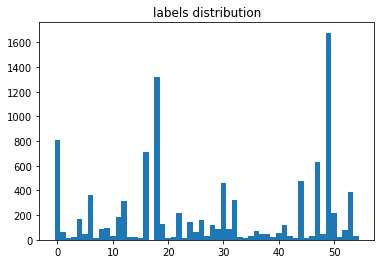

In [21]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [22]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 69.43 (7127 / 10265), f1 (weighted): 69.35, loss: 1.49e+00\nCPU time: 148s, wall time: 137s',
 69.43010228933268,
 69.34914950241057,
 1.494190350684432)

In [ ]:
#predictions = model.predict(x_test)

In [23]:
probabilities = model.probs(x_test, nclass)
#probabilities = np.log(probabilities)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    ids_test = ids_test[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [24]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_equiangular_SGD/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_equiangular_SGD/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [44]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

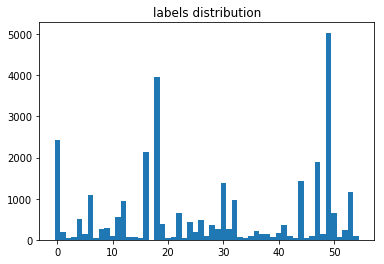

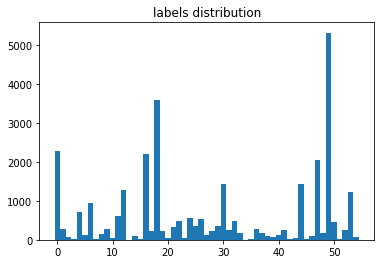

In [45]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)

In [25]:
del test_dataset
del train_dataset
del val_dataset

In [22]:
import tensorflow as tf
tf.reset_default_graph()

### Build Equiangular weight matrix

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [485]:
import os
import sys
import hashlib
import zipfile

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import healpy as hp

plt.rcParams['figure.figsize'] = [10, 10]

In [6]:
import numpy as np
from scipy import sparse

from pygsp import utils
from pygsp.graphs import Graph
from pygsp.graphs import NNGraph

In [30]:
class SphereIcosahedron(Graph):
    def __init__(self, order, sampling='vertex', **kwargs):
        from collections import deque
        ## sampling in ['vertex', 'face']
        PHI = (1 + math.sqrt(5))/2
#         x, y, z = 
#         pointUpFor = deque([0, 1, PHI])
#         pointUpBack = deque([0, -1, PHI])
#         pointDownFor = deque([0, 1, -PHI])
#         pointDownBack = deque([0, -1, -PHI])
#         for i in range(3):
            
#         theta = [0] + 5*[np.pi/2-np.arctan(0.5)] + 5*[np.pi/2+np.arctan(0.5)] + [np.pi]
#         phi = [0] + np.linspace(0, 2*np.pi, 5, endpoint=False).tolist() +  (np.linspace(0, 2*np.pi, 5, endpoint=False)+(np.pi/5)).tolist() + [0]
        
        coords = 0
        W = 0
        super(SphereIcosahedron, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

In [23]:
class SphereHealpixNN(NNGraph):
    def __init__(self, nside, n_neighbors, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        plotting = {
            'vertex_size': 80,
            "limits": np.array([-1, 1, -1, 1, -1, 1])
        }
        
        super(SphereHealpixNN, self).__init__(coords, k=n_neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)
        

In [188]:
class SphereHealpix(Graph):
    def __init__(self, nside, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)
        col_index = neighbors.T.reshape((npix * 8))
        row_index = np.repeat(indexes, 8)
        keep = (col_index < npix)
        # Remove fake neighbors (some pixels have less than 8).
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        plt.hist(distances, 100)
        kernel_width = np.mean(distances)
        weights = np.exp(-distances / (2 * kernel_width))
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereHealpix, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)
        

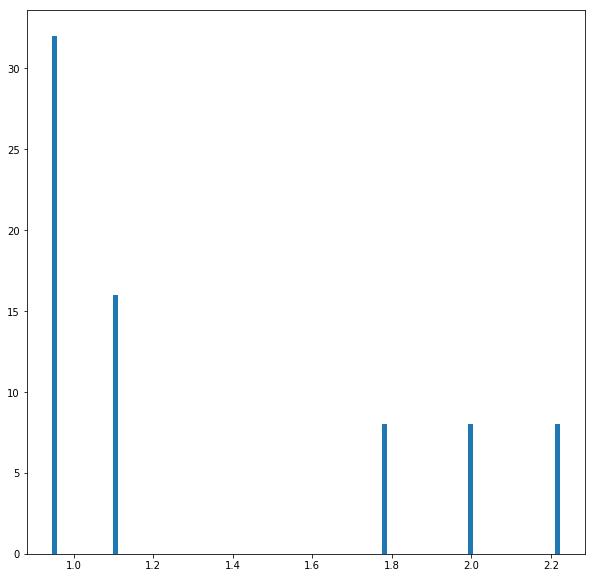

In [486]:
graphHp = SphereHealpix(1, True)
graphHpNN = SphereHealpixNN(1, 6, True)

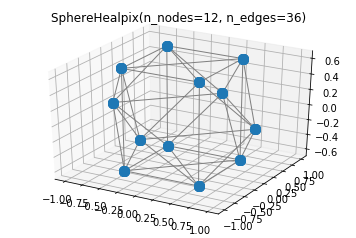

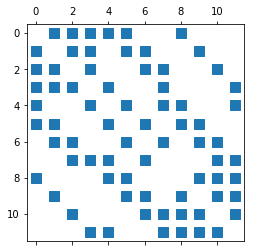

In [40]:
graphHp.plot()
plt.figure()
plt.spy(graphHp.W)

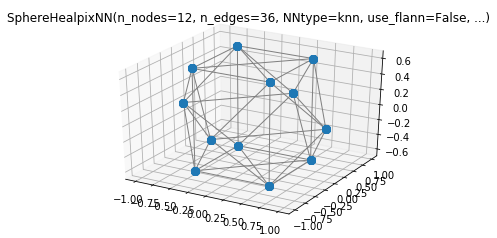

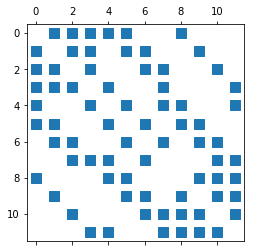

In [41]:
graphHpNN.plot()
plt.figure()
plt.spy(graphHpNN.W)

In [580]:
class SphereEquiangular(Graph):
    def __init__(self, bw=64, sptype='DH', pole='all', neighbors=8, weights=None, dist='geodesic', 
                 affine=0., **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the sphere, possible arguments are 'all', 'one', 'zero' (default = 'all')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'one', 'zero']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        
        ## neighbors and weight matrix calculation
        def south(x, bw):
            if x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
            elif self.pole is 'zero' and x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw-1),bw)
            else:
                return x + 2*bw

        def north(x, bw):
            if x < 2*bw:
                return (x+bw)%(2*bw)
            else:
                return x - 2*bw

        def west(x, bw):
            if x%(2*bw)==0:
                x += 2*bw
            return x -1

        def east(x, bw):
            if x%(2*bw)==2*bw-1:
                x -= 2*bw
            return x + 1

        npix = len(coords)
        col_index=[]
        for ind in range(len(coords)):
            # first line is the same point, so is connected to all points of second line
            if pole is 'all' and sptype and ind < 2* bw:
                if ind == 0:
                    neighbor = np.arange(2*bw)+2*bw # np.arange(1,4*bw)
                else:
                    neighbor = np.arange(2*bw)+2*bw # [0]
            elif pole is 'all' and ind < 4*bw:
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += list(range(2*bw)) # [0]
            elif pole is 'one' and ind == 0:
                neighbor = np.arange(1, 2*bw+1)
            elif pole is 'one' and ind < 2*bw+1:
                ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += [0]
            else:
                if pole is 'one':
                    ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                                north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), north(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
            neighbor = np.asarray(neighbor)
            if pole is 'one' and ind != 0:
                neighbor -= 2*bw - 1
                neighbor[neighbor<0] = 0
            #neighbors.append(neighbor)
            col_index += list(neighbor)
        # neighbors = np.asarray(neighbors)
        col_index = np.asarray(col_index)

        #col_index = neighbors.reshape((-1))
        if pole is 'all':
            row_index = np.hstack([np.repeat(np.arange(0,2*bw), 2*bw), np.repeat(np.arange(2*bw,4*bw), neighbors//2+1+2*bw),#2*bw+5), 
                                  np.repeat(np.arange(4*bw, npix), neighbors)])
        elif pole is 'one':
            row_index = np.hstack([np.repeat(0, 2*bw), np.repeat(np.arange(1, 2*bw+1), neighbors//2+2),
                                  np.repeat(np.arange(2*bw+1, npix), neighbors)])
        elif pole is 'zero':
            row_index = np.repeat(np.arange(npix), neighbors)

        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2
        if dist=='geodesic':
            distances = np.zeros(len(row_index))
            for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)

        # Compute similarities / edge weights.
        kernel_width = np.mean(distances)
        kernel_width2 = np.median(distances)
#         distances = kernel_width*(distances/kernel_width) ** 0.1
        slope = (kernel_width*(0.95-affine))/(kernel_width*0.95)
        distances[distances<(kernel_width*0.95)] = affine*kernel_width + distances[distances<(kernel_width*0.95)] * slope
#         distances[distances<(kernel_width*0.8)] = kernel_width*0.8
#         distances[distances>(kernel_width)] = kernel_width
#         distances[distances<(kernel_width)] = kernel_width*(distances[distances<(kernel_width)]/kernel_width) ** 0.05#kernel_width*0.8
#         distances[distances>(kernel_width)] = kernel_width*(distances[distances>(kernel_width)]/kernel_width) ** 0.5#distances[distances>(kernel_width*1.3)]/2
        if isinstance(weights, int):
            kernel_width = weights
        weights = np.exp(-distances / (2 * kernel_width))
        
        plt.hist(distances, 100)
        
        if weights == 'one':
            weights = distances/distances


        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


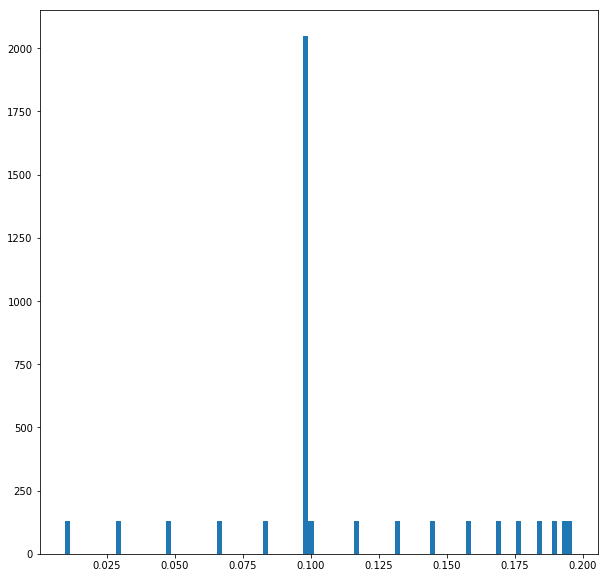

In [581]:
graphAll = SphereEquiangular(16, 'SOFT', 'zero', 4)

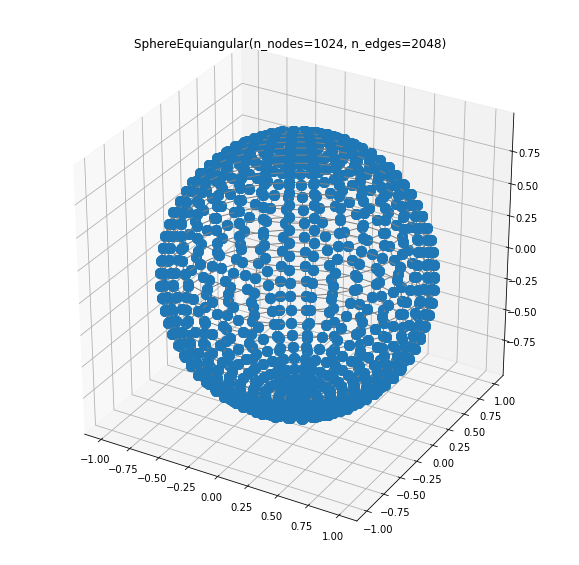

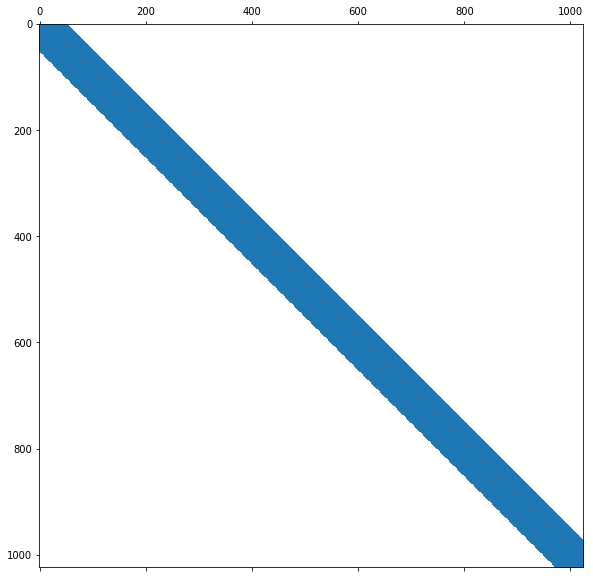

In [488]:
graphAll.plot()
plt.figure()
plt.spy(graphAll.W)

In [45]:
graphAll = SphereEquiangular(2, 'DH', 'all')

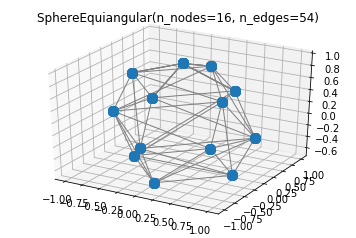

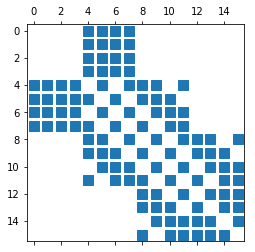

In [46]:
graphAll.plot()
plt.figure()
plt.spy(graphAll.W)

In [47]:
graphOne = SphereEquiangular(2, 'DH', 'one')

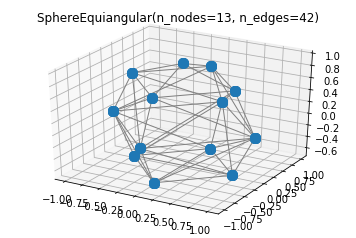

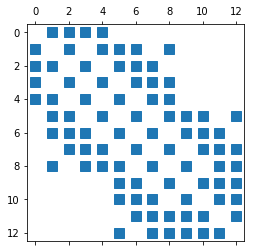

In [48]:
graphOne.plot()
plt.figure()
plt.spy(graphOne.W)

In [49]:
graphZero = SphereEquiangular(2, 'DH', 'zero')

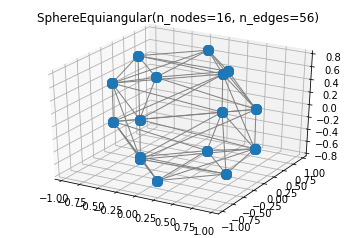

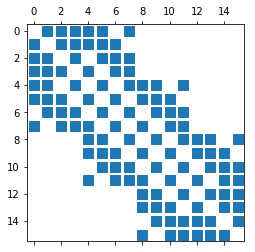

In [50]:
graphZero.plot()
plt.figure()
plt.spy(graphZero.W)

pole can be only zero with sampling type SOFT


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


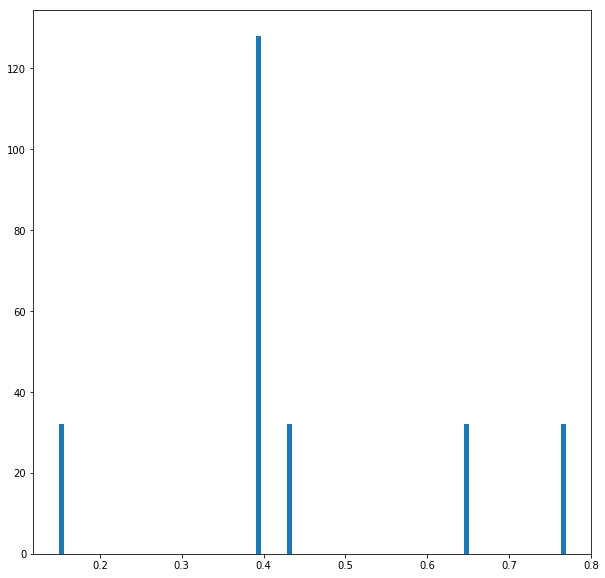

In [594]:
graphAll = SphereEquiangular(4, 'SOFT', 'all', 4, dist='geodesic', affine=0.)

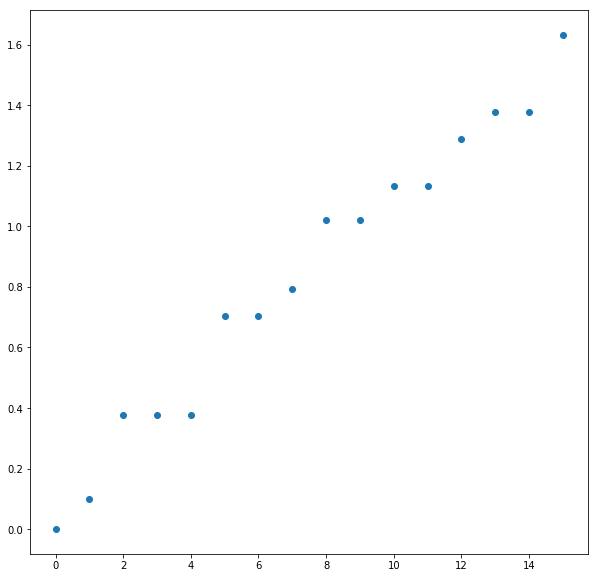

In [596]:
plt.plot(graphAll.e[:16], 'o')

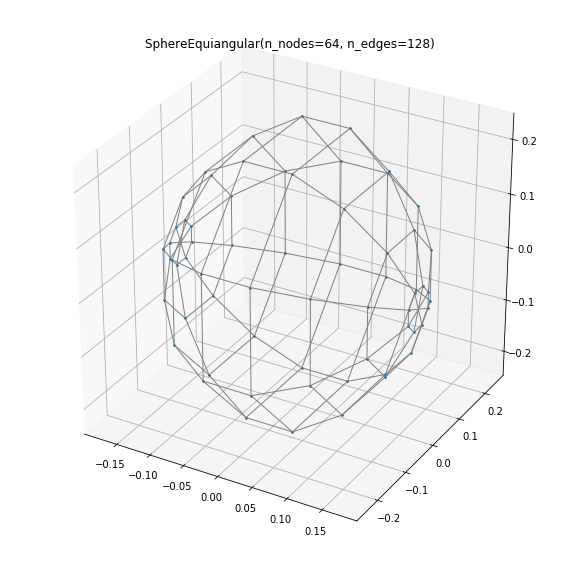

<Figure size 720x720 with 0 Axes>

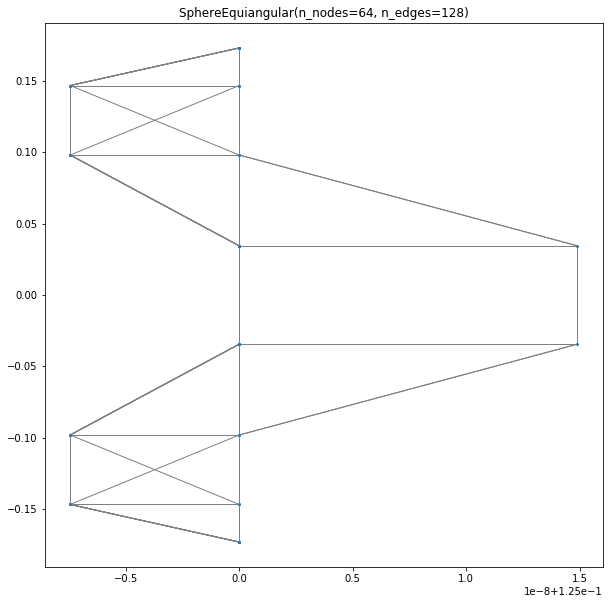

In [599]:
graphAll.compute_laplacian("normalized")
#graphAll.compute_fourier_basis(recompute=True)
graphAll.set_coordinates(graphAll.U[:,1:4])
graphAll.plot(vertex_size=10)
fig=plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(graphAll.U[:,0], graphAll.U[:,1], graphAll.U[:,2])

graphAll.set_coordinates(graphAll.U[:,0:2])
graphAll.plot(vertex_size=10)

## Shrec projection outside

In [610]:
from SHREC17.load_shrec import plot_healpix_projection, cache_healpix_projection

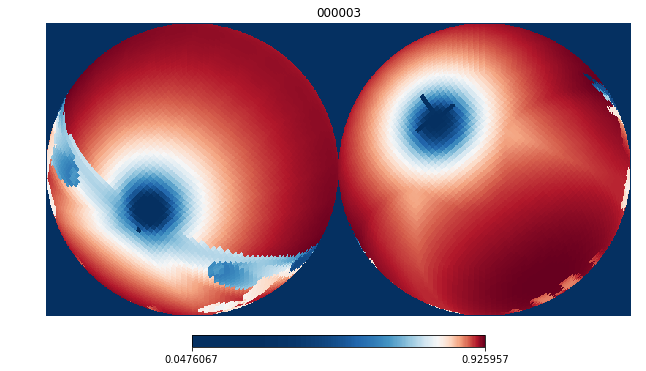

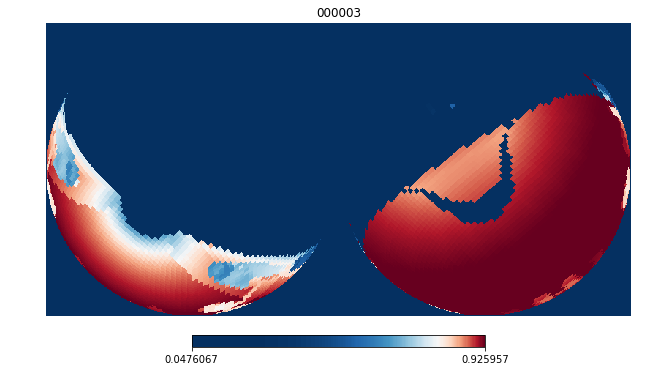

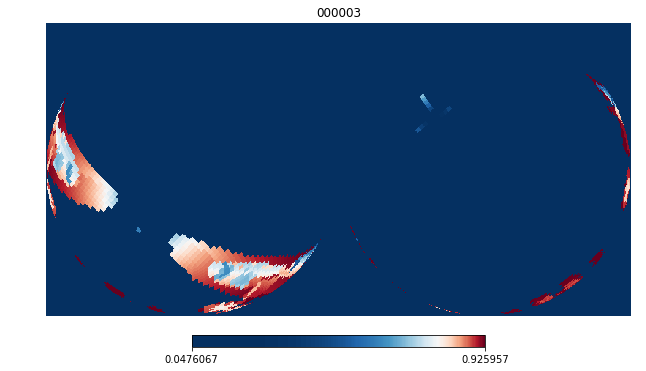

In [665]:
im1=plot_healpix_projection('../data/shrec17/train_perturbed/000003.obj',32, outside=False, rot=False, multiple=True)

In [ ]:
cache_healpix_projection('../data/shrec17/', 'val', 32, repeat=3, outside='equator', rot=False)

 30%|███       | 1543/5133 [1:28:44<3:26:27,  3.45s/it]

In [59]:
im1[np.where(im1==0.)]=np.nan

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


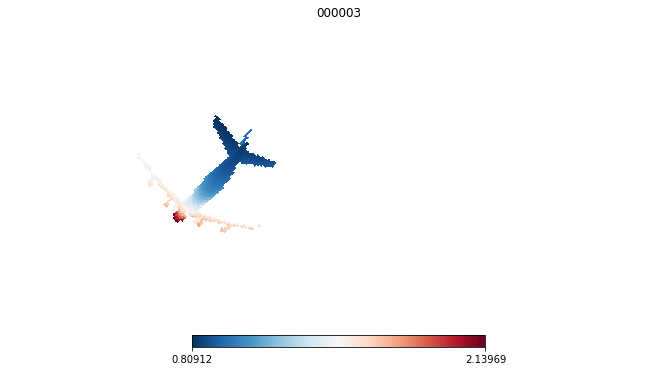

In [60]:
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.nanmin(im1)
cmax = np.nanmax(im1)
hp.orthview(im1, title='000003', nest=True, cmap=cm, min=cmin, max=cmax)

In [36]:
indexes = np.where(np.invert(np.isnan(im1)))[0]
npix = len(indexes)